# Collisions and injuries near rail stations
* Layer different kinds of geospatial data together (points and polygons)
* Here, we have collision data (points) that we want to join to census blocks. 
* Then, we want to calculate some summary statistics at the census block level (# collisions, # killed, # injured).
* We'll also merge in a parquet file from Demo1, which helps us aggregate without rewriting code.
* Finally, we'll merge in collision information to our geojson file from Demo1.
* Make charts and maps within notebook, which means we haven't created any additional outputs in this notebook.

In [1]:
import pandas as pd
import numpy as np
import intake
import os
import geopandas as gpd
import altair.vegalite.v2 as alt
import folium
import xlsxwriter
import utils
from shapely.geometry import Point

In [2]:
cd demo/

[Errno 2] No such file or directory: 'demo/'
/home/jovyan/demo


## I. Import data 
### A. Import collisions file
* These are 2018 fatal or severe collisions
* Attach points to census tracts

In [3]:
collision = gpd.read_file('./gis/collision_demo.geojson')

In [4]:
# Generate the geometry column again using (point_x, point_y), then project to EPSG:2229 to match census blocks
collision['geometry'] = collision.apply(
    lambda row: Point(row.point_x, row.point_y), axis=1
)

In [5]:
collision = collision.to_crs({'init':'epsg:2229'})

In [6]:
collision.columns

Index(['OBJECTID', 'case_id', 'accident_year', 'proc_date', 'juris',
       'collision_date', 'collision_time', 'officer_id', 'reporting_district',
       'day_of_week', 'chp_shift', 'population', 'cnty_city_loc',
       'special_cond', 'beat_type', 'chp_beat_type', 'city_division_lapd',
       'chp_beat_class', 'beat_number', 'primary_rd', 'secondary_rd',
       'distance', 'direction', 'intersection', 'weather_1', 'weather_2',
       'state_hwy_ind', 'caltrans_county', 'caltrans_district', 'state_route',
       'route_suffix', 'postmile_prefix', 'postmile', 'location_type',
       'ramp_intersection', 'side_of_hwy', 'tow_away', 'collision_severity',
       'number_killed', 'number_injured', 'party_count', 'primary_coll_factor',
       'pcf_code_of_viol', 'pcf_viol_category', 'pcf_violation',
       'pcf_viol_subsection', 'hit_and_run', 'type_of_collision', 'mviw',
       'ped_action', 'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'chp_road_type', 

In [7]:
keep = ['case_id', 'collision_severity', 'geometry', 'number_killed', 'number_injured']
collision = collision[keep]

### B. Import census blocks
* Use the output from Demo1

In [8]:
block = gpd.read_file('./gis/census_block_characteristics_near_rail.geojson')

In [9]:
block_abbrev = block[['GEOID', 'geometry']]

## II. Spatial join - attach collisions to census blocks

In [10]:
sjoin = gpd.sjoin(collision, block_abbrev, how='inner', op='intersects')
sjoin.head()

,case_id,collision_severity,geometry,number_killed,number_injured,index_right,GEOID
0,8843158,2,POINT (6461905.141002319 1858201.299151639),0,1,524,060371908022
964,8563286,0,POINT (6461444.976495164 1858205.587678959),0,0,524,060371908022
1497,8578113,0,POINT (6461395.074359396 1858204.363820617),0,0,524,060371908022
1935,8578109,0,POINT (6461930.063885223 1857498.764190967),0,0,524,060371908022
2203,8514085,0,POINT (6462107.758779001 1857209.426832316),0,0,524,060371908022


In [11]:
# sjoin output is that every point is linked to a GEOID
# Sum up the number of collisions, number killed, and number injured for each census block
sjoin2 = sjoin.pivot_table(index='GEOID', values=['case_id', 'number_killed', 'number_injured'], 
                  aggfunc={'case_id': 'count', 'number_killed':'sum', 'number_injured':'sum'}).reset_index()
sjoin2.head()

,GEOID,case_id,number_injured,number_killed
0,060371241022,7,1,0
1,060371242041,10,0,0
2,060371242042,6,0,0
3,060371243003,4,0,0
4,060371252001,4,1,0


In [12]:
sjoin2.rename(columns={'case_id':'collisions',
                      'number_killed': 'killed',
                      'number_injured': 'injured'}, inplace=True)

## III. Merge collision information onto census block file

In [13]:
merge = pd.merge(block, sjoin2, on='GEOID', how='left')
merge.head()

,GEOID,Blue,Expo,Gold,Green,Purple,Red,keep_block,housing_units,pop,...,acres,housing_units_acre,pop_acre,owner_pop_acre,renter_pop_acre,emp_acre,geometry,collisions,injured,killed
0,060372122042,0.0,0.0,0.0,0.0,1.0,1.0,1.0,732,1932,...,14.898943,49.131002,129.673627,6.711885,122.961742,4.362726,"POLYGON ((6474107.097197829 1843873.789287847,...",5.0,1.0,0.0
1,060372094031,0.0,0.0,0.0,0.0,1.0,1.0,1.0,787,1629,...,17.494330,44.986004,93.115883,0.000000,93.115883,10.632016,"POLYGON ((6478507.520417627 1842668.155661697,...",8.0,0.0,0.0
2,060375327001,1.0,0.0,0.0,0.0,0.0,0.0,1.0,363,1567,...,62.610415,5.797757,25.027785,7.666456,17.361329,3.625595,"POLYGON ((6486564.571323734 1818650.980400814,...",NaN,NaN,NaN
3,060372117032,0.0,0.0,0.0,0.0,1.0,0.0,1.0,898,1939,...,22.762982,39.450015,85.182160,16.913425,68.268735,1.405791,"POLYGON ((6466547.774524551 1847625.203366093,...",3.0,2.0,0.0
4,060372220021,0.0,1.0,0.0,0.0,0.0,0.0,1.0,483,1473,...,41.324583,11.687958,35.644643,12.341322,23.303321,2.177880,"POLYGON ((6465418.791555855 1831829.104294554,...",16.0,2.0,0.0


In [14]:
for col in ['collisions', 'killed', 'injured']:
    merge[col] = merge[col].fillna(0)

### Normalize by area
* Use variable in utils!

In [15]:
colnames = ['collisions', 'killed', 'injured']

for old_col in colnames:
    new_col = f"{old_col}_acre"
    merge[new_col] = merge[old_col] / utils.feet_in_acres

In [16]:
merge.head()

,GEOID,Blue,Expo,Gold,Green,Purple,Red,keep_block,housing_units,pop,...,owner_pop_acre,renter_pop_acre,emp_acre,geometry,collisions,injured,killed,collisions_acre,killed_acre,injured_acre
0,060372122042,0.0,0.0,0.0,0.0,1.0,1.0,1.0,732,1932,...,6.711885,122.961742,4.362726,"POLYGON ((6474107.097197829 1843873.789287847,...",5.0,1.0,0.0,0.000115,0.0,0.000023
1,060372094031,0.0,0.0,0.0,0.0,1.0,1.0,1.0,787,1629,...,0.000000,93.115883,10.632016,"POLYGON ((6478507.520417627 1842668.155661697,...",8.0,0.0,0.0,0.000184,0.0,0.000000
2,060375327001,1.0,0.0,0.0,0.0,0.0,0.0,1.0,363,1567,...,7.666456,17.361329,3.625595,"POLYGON ((6486564.571323734 1818650.980400814,...",0.0,0.0,0.0,0.000000,0.0,0.000000
3,060372117032,0.0,0.0,0.0,0.0,1.0,0.0,1.0,898,1939,...,16.913425,68.268735,1.405791,"POLYGON ((6466547.774524551 1847625.203366093,...",3.0,2.0,0.0,0.000069,0.0,0.000046
4,060372220021,0.0,1.0,0.0,0.0,0.0,0.0,1.0,483,1473,...,12.341322,23.303321,2.177880,"POLYGON ((6465418.791555855 1831829.104294554,...",16.0,2.0,0.0,0.000367,0.0,0.000046


In [17]:
merge[['collisions', 'killed', 'injured', 'collisions_acre', 'killed_acre', 'injured_acre']].describe()

,collisions,killed,injured,collisions_acre,killed_acre,injured_acre
count,924.000000,924.000000,924.000000,924.000000,9.240000e+02,924.000000
mean,4.859307,0.040043,0.495671,0.000112,9.192674e-07,0.000011
std,9.192283,0.206918,1.322766,0.000211,4.750190e-06,0.000030
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,2.000000,0.000000,0.000000,0.000046,0.000000e+00,0.000000
75%,7.000000,0.000000,0.000000,0.000161,0.000000e+00,0.000000
max,104.000000,2.000000,11.000000,0.002388,4.591368e-05,0.000253


### Merge in crosswalk and attach rail line information to each census block

In [18]:
crosswalk = pd.read_parquet('./data/crosswalk_geoid_line.parquet')

In [19]:
df = pd.merge(merge, crosswalk, on='GEOID')

## IV. Make charts and maps

In [20]:
collisions = df[['GEOID', 'collisions']]

bins = [0, 1, 10, 20, 105]

m = folium.Map(
    location=[34.0536, -118.2427], 
    zoom_start=12, 
    tiles='cartodbpositron'
)


# Add the color for the chloropleth:
m.choropleth(
    geo_data=df[['GEOID', 'geometry']],
    name = 'choropleth',
    data=collisions,
    columns=['GEOID', 'collisions'],
    key_on='feature.properties.GEOID',
    fill_color='YlOrRd',
    fill_opacity=0.95,
    line_opacity=0.8, line_color='white',
    bins=bins,
    legend_name='Number of Fatal and Severe Collisions, 2018'
)

folium.LayerControl().add_to(m)

m

/opt/conda/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [21]:
# Sum up number of collisions and number killed by line
pivot = df.pivot_table(index='line', values=['collisions', 'killed', 'injured', 'collisions_acre', 'killed_acre', 'injured_acre'], 
                       aggfunc='sum').reset_index()
pivot

,line,collisions,collisions_acre,injured,injured_acre,killed,killed_acre
0,Blue,1092.0,0.025069,103.0,0.002365,7.0,0.000161
1,Expo,1278.0,0.029339,138.0,0.003168,6.0,0.000138
2,Gold,940.0,0.021579,69.0,0.001584,5.0,0.000115
3,Green,412.0,0.009458,50.0,0.001148,4.0,0.000092
4,Purple,1285.0,0.029500,133.0,0.003053,10.0,0.000230
5,Red,1973.0,0.045294,204.0,0.004683,17.0,0.000390


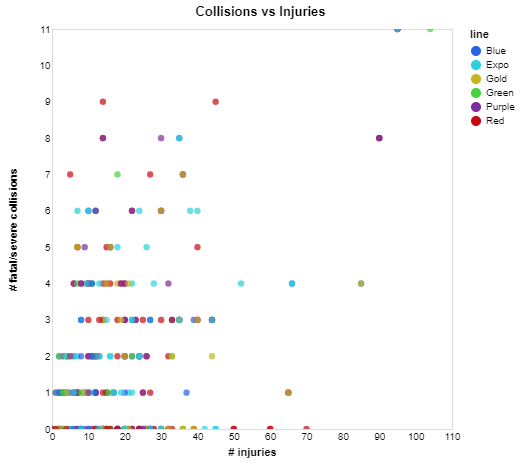

In [22]:
# Drop geometry column because Altair can't use geodataframes
df2 = df.drop(columns='geometry')

scatter = alt.Chart(df2).mark_circle(size=40, fillOpacity=0.7).encode(
    x='sum(collisions):Q',
    y='sum(injured):Q',
    color=alt.Color('line',
        scale = alt.Scale(domain=['Blue', 'Expo', 'Gold', 'Green', 'Purple', 'Red'],
                          range=['#2563eb', '#28d2de', '#c6b51e', '#43d43c', '#812c9e', '#c50a14'])
    ),
    tooltip = ['line', 'collisions', 'killed', 'injured']
).interactive()

scatter.encoding.x.title= '# injuries'
scatter.encoding.y.title = '# fatal/severe collisions'

alt.layer(scatter).configure_view(
    strokeOpacity=0, strokeWidth=0).configure(
    countTitle=' ').configure_scale(
    bandPaddingInner=0.2
    ).configure_axis(
    grid=False, ticks=False, labelAngle=0, domainWidth=0).configure_axisY(
    labelColor='black').properties(
    height=400, width=400, title='Collisions vs Injuries')
